# Velocity & Acceleration Data Analysis


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter

import os
import re

import scipy.stats as stats
import seaborn as sns
import pingouin as pg

## Initial Processing

Time:

- Time is currently organized by STEP. Given a frequency of 100Hz, re-organize into millisecond timesteps starting at zero


In [3]:
data = {}

sampling_rate = 100
step_interval_ms = 1000 / sampling_rate

for participant in os.listdir("Experiment Data"):
    participant_path = os.path.join("Experiment Data", participant)

    # Ignore .DS_Store
    if not os.path.isdir(participant_path):
        continue

    data[participant] = {}

    for csv_file in os.listdir(participant_path):
        file_path = os.path.join(participant_path, csv_file)

        df = pd.read_csv(file_path, encoding='ISO-8859-1', sep=';')

        df['Milliseconds'] = (df.index * step_interval_ms).astype(int)
        data[participant][csv_file] = df

        output_path = os.path.join("Processed CSVs", csv_file)
        df.to_csv(output_path, index=False)

Stopping Sight Distance:

- Add a column for driver's stopping sight distance (SSD) at each time step, calculated based on VI_CarRealTime.Outputs.chassis_velocities.longitudinal
- If Simulink data was available, add a column for SSD - Roundabout.EgoPedEuclideanDistance, where a lower difference is worse
- Source: https://tc.canada.ca/en/rail-transportation/grade-crossings/grade-crossings-handbook/part-c-design-calculations

Acceleration

- Add a column that converts longitudinal acceleration [g] to m/s^2
- This will be used to study the driver's braking deceleration, where 3.4 m/s^2 is considered the safe cutoff


In [4]:
def calculate_SSD(v, f=0.38):
    return ( 0.278 * 2.5 * v ) + ( v**2 / ( 254 * f ) )

def convert_acceleration(g):
    return g * 9.81

In [5]:
for csv_file in os.listdir("Processed CSVs"):
    file_path = os.path.join("Processed CSVs", csv_file)

    # Ignore .DS_Store
    if not os.path.isdir(participant_path):
        continue

    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip()

    if 'VI_CarRealTime.Outputs.chassis_velocities.longitudinal' in df.columns:
        df["SSD"] = df['VI_CarRealTime.Outputs.chassis_velocities.longitudinal'].apply(calculate_SSD)
        df["Actual Distance - SSD"] = df["Roundabout.EgoPedEuclideanDistance"] - df["SSD"]
        df["Longitudinal Acceleration"] = df["VI_CarRealTime.Outputs.chassis_accelerations.longitudinal"].apply(convert_acceleration)
        df.to_csv(file_path, index=False)
    else:
        print(f"{csv_file}")

.DS_Store


Independent variable dict.


In [5]:
trial_IVs = {
    1: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 2 + crosswalk", 
        "Pedestrian Crossing": "Straight ahead"
    },
    2: {
        "Driver's Direction": "Straight (left lane)", 
        "Alert Combination": "Crosswalk", 
        "Pedestrian Crossing": "To driver’s left"
    },
    3: {
        "Driver's Direction": "Straight (right lane)", 
        "Alert Combination": "No alert", 
        "Pedestrian Crossing": "To driver’s left"
    },
    4: {
        "Driver's Direction": "Straight (right lane)", 
        "Alert Combination": "Sign 2 + crosswalk", 
        "Pedestrian Crossing": "To driver’s right"
    },
    5: {"Driver's Direction": "Left", 
        "Alert Combination": "Sign 3", 
        "Pedestrian Crossing": "To driver’s left"
    },
    6: {
        "Driver's Direction": "Straight (left lane)", 
        "Alert Combination": "No alert", 
        "Pedestrian Crossing": "To driver’s right"
    },
    7: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 3 + crosswalk", 
        "Pedestrian Crossing": "To driver’s left"
    },
    8: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 3 + crosswalk", 
        "Pedestrian Crossing": "Straight ahead"
    },
    9: {
        "Driver's Direction": "Straight (right lane)", 
        "Alert Combination": "Sign 3", 
        "Pedestrian Crossing": "Straight ahead"
    },
    10: {
        "Driver's Direction": "Right", 
        "Alert Combination": "Crosswalk", 
        "Pedestrian Crossing": "Straight ahead"
    },
    11: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Sign 2", 
        "Pedestrian Crossing": "To driver’s right"
    },
    12: {
        "Driver's Direction": "Right", 
        "Alert Combination": "Sign 3", 
        "Pedestrian Crossing": "To driver’s right"
    },
    13: {
        "Driver's Direction": "Left", 
        "Alert Combination": "Crosswalk", 
        "Pedestrian Crossing": "To driver’s left"
    },
    14: {
        "Driver's Direction": "Right", 
        "Alert Combination": "Sign 2", 
        "Pedestrian Crossing": "To driver’s left"
    },
    15: {
        "Driver's Direction": "Straight (left lane)", 
        "Alert Combination": "Sign 2", 
        "Pedestrian Crossing": "Straight ahead"
    },
    16: {
        "Driver's Direction": "Left", 
        "Alert Combination": "No alert", 
        "Pedestrian Crossing": "To driver's left"
    }
}

## SSD Analysis


### Pre-Processing

- Put CSVs in a meaningful format for analyzing SSD (stopping sight distance) vs. actual distance from the pedestrian, around the time when the vehicle approaches the pedestrian.
- We want a larger difference between actual distance & SSD to indicate that the driver had more room to stop
- The entry trigger data didn't end up registering, so start analyzing SSD when the driver is about within braking distance from the pedestrian, and stop analyzing once the driver reaches their minimum distance to the pedestrian (after which SSD is irrelevant)
- Ignoring trials where the driver never encounters the pedestrian (i.e. doesn't ever see the pedestrian)


In [7]:
relevant_trials = {1, 4, 5, 6, 7, 8, 9, 11, 12, 13, 15, 16}

input_dir = "Processed CSVs"
output_dir = "SSD Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip irrelevant trials where driver never sees pedestrian
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # This distance is around 1/4 of the roundabout, where driver might prepare to stop for ped.
    distance_cutoff = 35

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    # Get the first row where distance from ped. conditions are met
    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Simulink model failed to capture distance from pedestrian
Skipping Hassan_6.csv: Simulink model failed to capture distance from pedestrian
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Simulink model failed to capture distance from pedestrian
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Azaan_14.csv: Trial 14 is not relevant
Skipping Azaan_10.csv: Trial 10 is not relevant
Skipping Hassan_1.csv: Simulink model failed to capture distance from pedestrian
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Azaan_11.csv: Simulink model failed to capture distance from pedestrian
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.csv: Trial 2 is not relevant
Skipping Serena_8.csv: Simulink model failed to capture distance from pedestrian
Skip

### Format for Statistical Analysis

- Compile data into one long-format CSV, with trial number, participant, and independent variable values labeled
- Take the mean Actual - SSD difference for each trial (DV of interest) to see if the alert type (IV of interest) has an affect on this. We'd want to see a higher average in general for a more effective alert.


In [8]:
input_dir = "SSD Analysis CSVs"
output_file = "Compiled_SSD_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    if "Actual Distance - SSD" not in df.columns:
        print(f"Skipping {file}: Missing 'Actual Distance - SSD' column.")
        continue

    # Mean of "Actual Distance - SSD" is the DV
    mean_ssd_diff = df["Actual Distance - SSD"].mean()

    # Add columns for independent variable values
    iv_data = trial_IVs[trial_number]

    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Mean_SSD_Diff": mean_ssd_diff,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)

compiled_df.to_csv(output_file, index=False)

### Repeated Measures ANOVA

- Using RM ANOVA since this is a within-subject experiment; all participants go through the same trials while Alert Type changes

First, check normality & sphericity conditions for running RM ANOVA:


Shapiro-Wilk Test for Normality: W=0.9380370378494263, p=8.035220162128098e-06


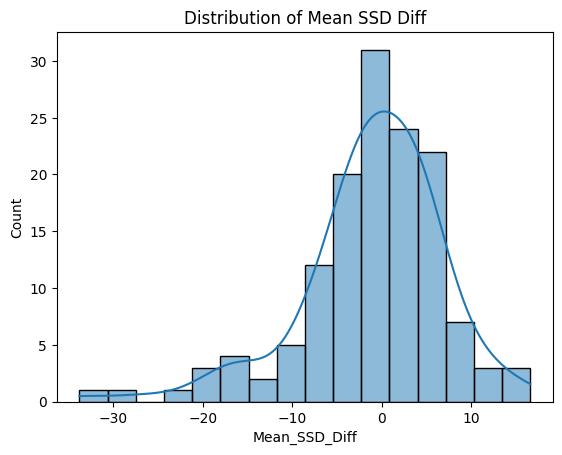

Duplicate entries found:
   Participant   Alert_Combination  Trial  Mean_SSD_Diff
8        Adity              Sign 2     11       9.403737
10       Adity              Sign 2     15       3.227173
68       Adity  Sign 2 + crosswalk      1       9.863128
96       Adity  Sign 2 + crosswalk      4       3.479587
4        Adity              Sign 3     12       3.775771
..         ...                 ...    ...            ...
24      Sabina              Sign 3     12      10.624140
55      Sabina              Sign 3      5       2.206853
71      Sabina              Sign 3      9       1.393724
43      Sabina  Sign 3 + crosswalk      7       3.627691
65      Sabina  Sign 3 + crosswalk      8       0.327636

[112 rows x 4 columns]

Missing values in pivoted data:
Alert_Combination
Crosswalk             3
No alert              1
Sign 2                0
Sign 2 + crosswalk    1
Sign 3                1
Sign 3 + crosswalk    1
dtype: int64

Number of participants with complete data: 11

Mauchly's t

In [9]:
df = pd.read_csv("Compiled_SSD_Data.csv")

# Check normality for Mean SSD Diff using Shapiro-Wilk Test
shapiro_results = stats.shapiro(df["Mean_SSD_Diff"])
print(f"Shapiro-Wilk Test for Normality: W={shapiro_results.statistic}, p={shapiro_results.pvalue}")

sns.histplot(df["Mean_SSD_Diff"], kde=True)
plt.title("Distribution of Mean SSD Diff")
plt.show()

# Pivot data into wide format for RM-ANOVA
df_wide = df.pivot(index="Participant", columns="Trial", values="Mean_SSD_Diff")

# Check if there are duplicates that would cause the pivot to fail
duplicates = df.duplicated(subset=["Participant", "Alert_Combination"], keep=False)
if duplicates.any():
    print("Duplicate entries found:")
    print(df[duplicates][["Participant", "Alert_Combination", "Trial", "Mean_SSD_Diff"]].sort_values(
        by=["Participant", "Alert_Combination"]))

# Use groupby to get the mean value for each participant-alert combination
df_mean = df.groupby(["Participant", "Alert_Combination"])["Mean_SSD_Diff"].mean().reset_index()

df_wide_alert = df_mean.pivot(index="Participant", columns="Alert_Combination", values="Mean_SSD_Diff")

print("\nMissing values in pivoted data:")
print(df_wide_alert.isnull().sum())

df_wide_alert_complete = df_wide_alert.dropna()
print(f"\nNumber of participants with complete data: {len(df_wide_alert_complete)}")

# Check Sphericity with Mauchly's test for Alert_Combination
if len(df_wide_alert_complete) >= 3:  # Need at least 3 participants for test
    sphericity_test = pg.sphericity(df_wide_alert_complete)
    print(f"\nMauchly's test for sphericity (Alert_Combination): {sphericity_test}")
else:
    print("\nNot enough complete cases to perform sphericity test")



Run Repeated-Measures ANOVA:


In [10]:
df = pd.read_csv("Compiled_SSD_Data.csv")

# RM ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Mean_SSD_Diff", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc analysis (analyze significance comparing pairs of IVs)
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Mean_SSD_Diff",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source           SS  DF         MS         F     p-unc  \
0  Alert_Combination   468.270745   5  93.654149  4.626464  0.001512   
1              Error  1012.156841  50  20.243137       NaN       NaN   

        ng2       eps  
0  0.132742  0.577603  
1       NaN       NaN  

Post-hoc tests:
              Contrast                   A                   B  Paired  \
0   Alert_Combination           Crosswalk            No alert    True   
1   Alert_Combination           Crosswalk              Sign 2    True   
2   Alert_Combination           Crosswalk  Sign 2 + crosswalk    True   
3   Alert_Combination           Crosswalk              Sign 3    True   
4   Alert_Combination           Crosswalk  Sign 3 + crosswalk    True   
5   Alert_Combination            No alert              Sign 2    True   
6   Alert_Combination            No alert  Sign 2 + crosswalk    True   
7   Alert_Combination            No alert              Sign 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa

Box plot to visualize differences:


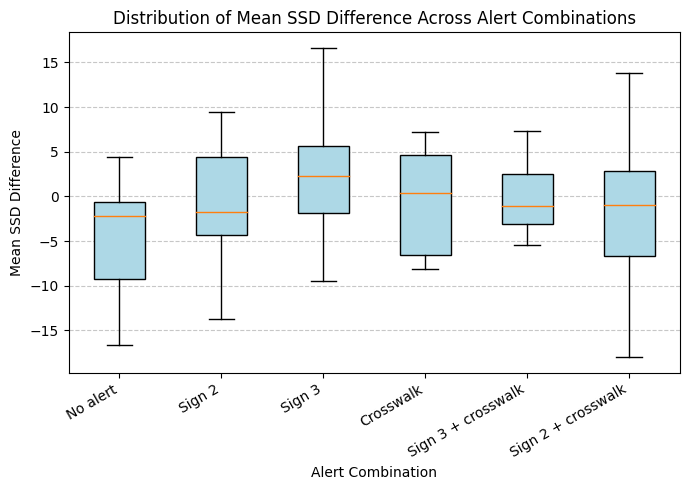

In [6]:
df = pd.read_csv("Compiled_SSD_Data.csv")

# Categorize data
categories = df["Alert_Combination"].unique()
data_by_category = [df[df["Alert_Combination"] == cat]["Mean_SSD_Diff"].values for cat in categories]

fig, ax = plt.subplots(figsize=(7, 5))

bp = ax.boxplot(data_by_category, patch_artist=True, labels=categories, showfliers=False)

for box in bp['boxes']:
    box.set(facecolor='lightblue')

ax.set_title("Distribution of Mean SSD Difference Across Alert Combinations")
ax.set_xlabel("Alert Combination")
ax.set_ylabel("Mean SSD Difference")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()

## Deceleration Analysis


### Pre-processing

- For this test, look only at trials where participants actually needed to brake for the pedestrian
- Around braking distance, extract the minimum acceleration (i.e. hardest deceleration)
- See if certain alerts led to less aggressive braking


In [2]:
relevant_trials = {5, 9, 13, 15, 16} # trials where braking for pedestrian would've happened

input_dir = "Processed CSVs"
output_dir = "Deceleration Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip irrelevant trials where driver does not need to brake for pedestrian
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    # Ignore trials where simulink didn't work
    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # This distance is around 1/4 of the roundabout, where driver would prepare to brake
    distance_cutoff = 35

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Trial 7 is not relevant
Skipping Adity_12.csv: Trial 12 is not relevant
Skipping Pete_8.csv: Trial 8 is not relevant
Skipping Hassan_6.csv: Trial 6 is not relevant
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Trial 4 is not relevant
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Adity_11.csv: Trial 11 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Azaan_14.csv: Trial 14 is not relevant
Skipping Azaan_10.csv: Trial 10 is not relevant
Skipping Hassan_1.csv: Trial 1 is not relevant
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Ionel_8.csv: Trial 8 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Pete_11.csv: Trial 11 is not relevant
Skipping Azaan_11.csv: Trial 11 is not relevant
Skipping Ionel_12.csv: Trial 12 is not relevant
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.c

### Format for Statistical Analysis


In [6]:
input_dir = "Deceleration Analysis CSVs"
output_file = "Compiled_Deceleration_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    if "Longitudinal Acceleration" not in df.columns:
        print(f"Skipping {file}: Missing 'Longitudinal Acceleration' column.")
        continue

    # Compute minimum acceleration within time window (most intense braking deceleration)
    min_acceleration = df["Longitudinal Acceleration"].min()

    # Add columns for independent variable values
    iv_data = trial_IVs[trial_number]

    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Min_Acceleration": min_acceleration,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)

compiled_df.to_csv(output_file, index=False)

### Repeated Measures ANOVA


Shapiro-Wilk Test for Normality: W=0.9331738352775574, p=0.005970479920506477


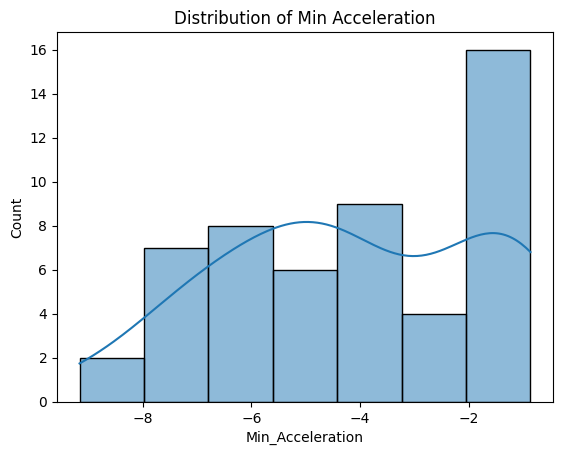

Duplicate entries found:
   Participant Alert_Combination  Trial  Min_Acceleration
13       Adity            Sign 3      9         -4.413603
35       Adity            Sign 3      5         -0.977612
11       Azaan            Sign 3      9         -6.338570
38       Azaan            Sign 3      5         -5.694557
21      Calvin            Sign 3      5         -1.995164
26      Calvin            Sign 3      9         -2.528739
15        Carl            Sign 3      9         -5.218915
36        Carl            Sign 3      5         -4.144898
17        Eric            Sign 3      5         -1.217628
28        Eric            Sign 3      9         -1.275463
8        Ionel            Sign 3      9         -7.033176
43       Ionel            Sign 3      5         -5.945206
16        Jenn            Sign 3      9         -4.758747
32        Jenn            Sign 3      5         -7.474659
12        Kapi            Sign 3      5         -0.864558
34        Kapi            Sign 3      9        

In [7]:
df = pd.read_csv("Compiled_Deceleration_Data.csv")

# Check normality using Shapiro-Wilk Test
shapiro_results = stats.shapiro(df["Min_Acceleration"])
print(f"Shapiro-Wilk Test for Normality: W={shapiro_results.statistic}, p={shapiro_results.pvalue}")

sns.histplot(df["Min_Acceleration"], kde=True)
plt.title("Distribution of Min Acceleration")
plt.show()

# Check if there are duplicates that would cause the pivot to fail
duplicates = df.duplicated(subset=["Participant", "Alert_Combination"], keep=False)
if duplicates.any():
    print("Duplicate entries found:")
    print(df[duplicates][["Participant", "Alert_Combination", "Trial", "Min_Acceleration"]].sort_values(
        by=["Participant", "Alert_Combination"]))

# Use groupby to get the mean value for each participant-alert combination
df_mean = df.groupby(["Participant", "Alert_Combination"])["Min_Acceleration"].mean().reset_index()

df_wide_alert = df_mean.pivot(index="Participant", columns="Alert_Combination", values="Min_Acceleration")

print("\nMissing values in pivoted data:")
print(df_wide_alert.isnull().sum())

df_wide_alert_complete = df_wide_alert.dropna()
print(f"\nNumber of participants with complete data: {len(df_wide_alert_complete)}")

# Check Sphericity with Mauchly's test for Alert_Combination
if len(df_wide_alert_complete) >= 3:  # Need 3 participants for test
    sphericity_test = pg.sphericity(df_wide_alert_complete)
    print(f"\nMauchly's test for sphericity (Alert_Combination): {sphericity_test}")
else:
    print("\nNot enough complete cases to perform sphericity test")

In [33]:
df = pd.read_csv("Compiled_Deceleration_Data.csv")

# Run repeated measures ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Min_Acceleration", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc tests
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Min_Acceleration",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source        SS  DF        MS         F     p-unc       ng2  \
0  Alert_Combination  1.685362   3  0.561787  1.140026  0.384207  0.020977   
1              Error  4.435064   9  0.492785       NaN       NaN       NaN   

        eps  
0  0.482178  
1       NaN  


Visualization:


                   mean  median   std
Alert_Combination                    
No alert          -4.69   -5.05  2.77
Sign 2            -4.18   -4.14  2.54
Sign 3            -4.15   -4.48  2.31
Crosswalk         -3.80   -4.07  2.73


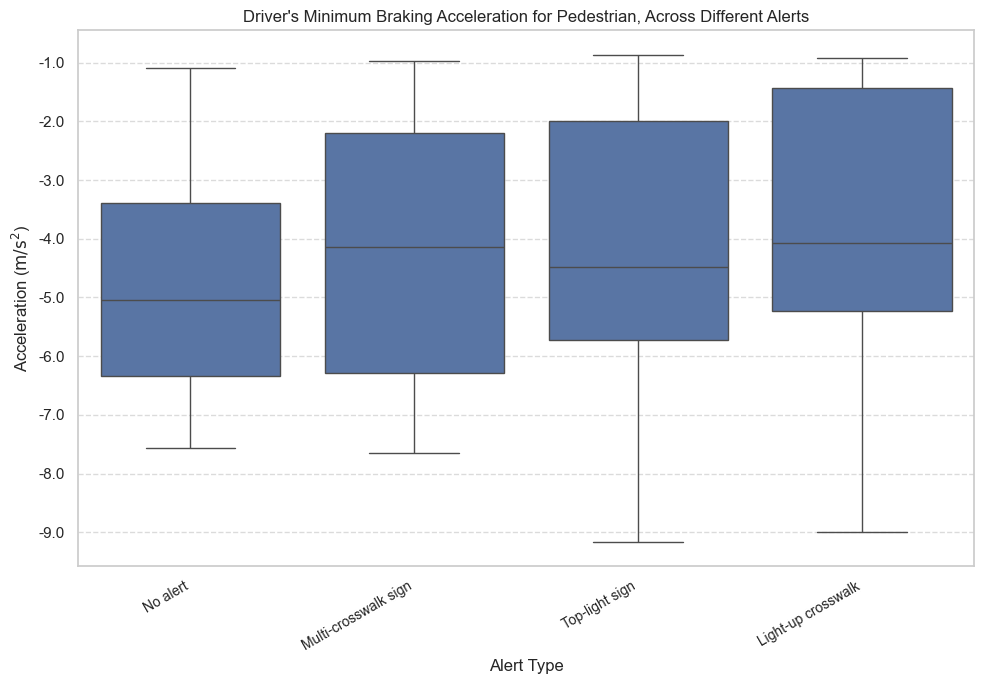

In [62]:
df = pd.read_csv("Compiled_Deceleration_Data.csv")

summary_stats = df.groupby("Alert_Combination")["Min_Acceleration"].agg(['mean', 'median', 'std']).sort_values(by="mean")
print(summary_stats.round(2))

df["Alert_Combination"] = (
    df["Alert_Combination"]
    .str.replace("Sign 2", "Multi-crosswalk sign", regex=False)
    .str.replace("Sign 3", "Top-light sign", regex=False)
    .str.replace("Crosswalk", "Light-up crosswalk", regex=False)
)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 7))

sns.boxplot(
    data=df,
    x="Alert_Combination",
    y="Min_Acceleration",
    showfliers=False,
    # showmeans=True,
    # meanline=True,
    # meanprops={
    #     'color': 'limegreen',
    #     'linewidth': 1.5
    # },
    # boxprops={
    #     'facecolor': '#006E51',
    #     'edgecolor': 'black'
    # },
    # medianprops={
    #     'color': 'none'
    # }
)

# Risk Threshold Line
# risk_level = -3.048
# plt.axhline(y=risk_level, color='orangered', linestyle='--', linewidth=2, label="Risk Threshold")

# plt.text(
#     x=len(df["Alert_Combination"].unique()) - 0.5,
#     y=risk_level - 0.4,
#     s=r"Hard braking events below $-3.048 \ \mathrm{m/s^2}$", 
#     color="orangered",
#     fontsize=10,
# )

plt.gca().yaxis.set_major_locator(MultipleLocator(1.0))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.title("Driver's Minimum Braking Acceleration for Pedestrian, Across Different Alerts")
plt.xlabel("Alert Type")
plt.ylabel(r"Acceleration ($\mathrm{m/s^2}$)")

plt.xticks(rotation=30, ha="right", fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Velocity Analysis


### Pre-processing

- In this test, compare mean velocity for different alerts while driver moves through roundabout
- Ignored right turns this time since you're not navigating the roundabout


In [18]:
relevant_trials = {1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 15, 16} # non right-turn trials

input_dir = "Processed CSVs"
output_dir = "Velocity Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip right turn trials since driver doesn't move through the roundabout
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # 50m is around half of the roundabout, so 1 straight pass or the meaningful part of 1 left pass
    distance_cutoff = 50

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    # Get the first row where distance from ped. conditions are met
    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Simulink model failed to capture distance from pedestrian
Skipping Adity_12.csv: Trial 12 is not relevant
Skipping Hassan_6.csv: Simulink model failed to capture distance from pedestrian
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Simulink model failed to capture distance from pedestrian
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Azaan_14.csv: Trial 14 is not relevant
Skipping Azaan_10.csv: Trial 10 is not relevant
Skipping Hassan_1.csv: Simulink model failed to capture distance from pedestrian
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Azaan_11.csv: Simulink model failed to capture distance from pedestrian
Skipping Ionel_12.csv: Trial 12 is not relevant
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.csv: Simulink mode

### Format for Statistical Analysis


In [19]:
input_dir = "Velocity Analysis CSVs"
output_file = "Compiled_Velocity_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    # Compute mean velocity while within roundabout
    avg_velocity = df["VI_CarRealTime.Outputs.chassis_velocities.longitudinal"].mean()

    # Add columns for independent variable values
    iv_data = trial_IVs[trial_number]

    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Avg_Velocity": avg_velocity,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)

compiled_df.to_csv(output_file, index=False)

### Repeated Measures ANOVA


Shapiro-Wilk Test for Normality: W=0.9289621710777283, p=1.5170061260505463e-06


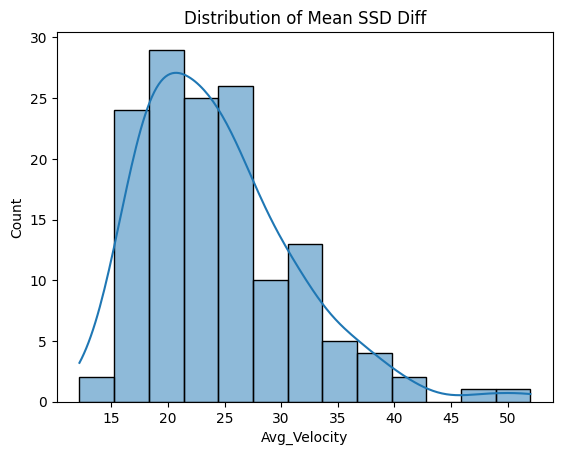

Duplicate entries found:
   Participant   Alert_Combination  Trial  Avg_Velocity
3        Adity           Crosswalk     13     23.603537
80       Adity           Crosswalk      2     40.847140
81       Adity            No alert      3     26.665062
92       Adity            No alert      6     25.400041
7        Adity              Sign 2     11     16.154100
..         ...                 ...    ...           ...
53      Sabina  Sign 2 + crosswalk      4     22.881378
56      Sabina              Sign 3      5     19.914691
72      Sabina              Sign 3      9     19.893707
44      Sabina  Sign 3 + crosswalk      7     16.918462
67      Sabina  Sign 3 + crosswalk      8     26.462023

[124 rows x 4 columns]

Missing values in pivoted data:
Alert_Combination
Crosswalk             1
No alert              1
Sign 2                0
Sign 2 + crosswalk    1
Sign 3                1
Sign 3 + crosswalk    1
dtype: int64

Number of participants with complete data: 13

Mauchly's test for sphe

In [20]:
df = pd.read_csv("Compiled_Velocity_Data.csv")

# Check normality using Shapiro-Wilk Test
shapiro_results = stats.shapiro(df["Avg_Velocity"])
print(f"Shapiro-Wilk Test for Normality: W={shapiro_results.statistic}, p={shapiro_results.pvalue}")

sns.histplot(df["Avg_Velocity"], kde=True)
plt.title("Distribution of Mean SSD Diff")
plt.show()

# Pivot data into wide format for RM-ANOVA
df_wide = df.pivot(index="Participant", columns="Trial", values="Avg_Velocity")

duplicates = df.duplicated(subset=["Participant", "Alert_Combination"], keep=False)
if duplicates.any():
    print("Duplicate entries found:")
    print(df[duplicates][["Participant", "Alert_Combination", "Trial", "Avg_Velocity"]].sort_values(
        by=["Participant", "Alert_Combination"]))

df_mean = df.groupby(["Participant", "Alert_Combination"])["Avg_Velocity"].mean().reset_index()

df_wide_alert = df_mean.pivot(index="Participant", columns="Alert_Combination", values="Avg_Velocity")

print("\nMissing values in pivoted data:")
print(df_wide_alert.isnull().sum())

df_wide_alert_complete = df_wide_alert.dropna()
print(f"\nNumber of participants with complete data: {len(df_wide_alert_complete)}")

# Check Sphericity with Mauchly's test for Alert_Combination
if len(df_wide_alert_complete) >= 3:
    sphericity_test = pg.sphericity(df_wide_alert_complete)
    print(f"\nMauchly's test for sphericity (Alert_Combination): {sphericity_test}")
else:
    print("\nNot enough complete cases to perform sphericity test")



In [21]:
df = pd.read_csv("Compiled_Velocity_Data.csv")

# Run repeated measures ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Avg_Velocity", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True,
    correction=True # Since sphericity failed, need to apply correction
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc tests
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Avg_Velocity",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source           SS  DF          MS         F     p-unc  \
0  Alert_Combination   552.292752   5  110.458550  4.313364  0.002033   
1              Error  1536.506739  60   25.608446       NaN       NaN   

   p-GG-corr       ng2       eps sphericity   W-spher   p-spher  
0   0.026577  0.189566  0.386777      False  0.018865  0.000331  
1        NaN       NaN       NaN        NaN       NaN       NaN  

Post-hoc tests:
              Contrast                   A                   B  Paired  \
0   Alert_Combination           Crosswalk            No alert    True   
1   Alert_Combination           Crosswalk              Sign 2    True   
2   Alert_Combination           Crosswalk  Sign 2 + crosswalk    True   
3   Alert_Combination           Crosswalk              Sign 3    True   
4   Alert_Combination           Crosswalk  Sign 3 + crosswalk    True   
5   Alert_Combination            No alert              Sign 2    True   
6   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: overflow encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: overflow encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packa

Visualize:


                    mean   std
Alert_Combination             
Sign 3             21.26  4.06
Sign 2             22.02  4.46
No alert           27.62  7.83
Crosswalk          27.91  9.54


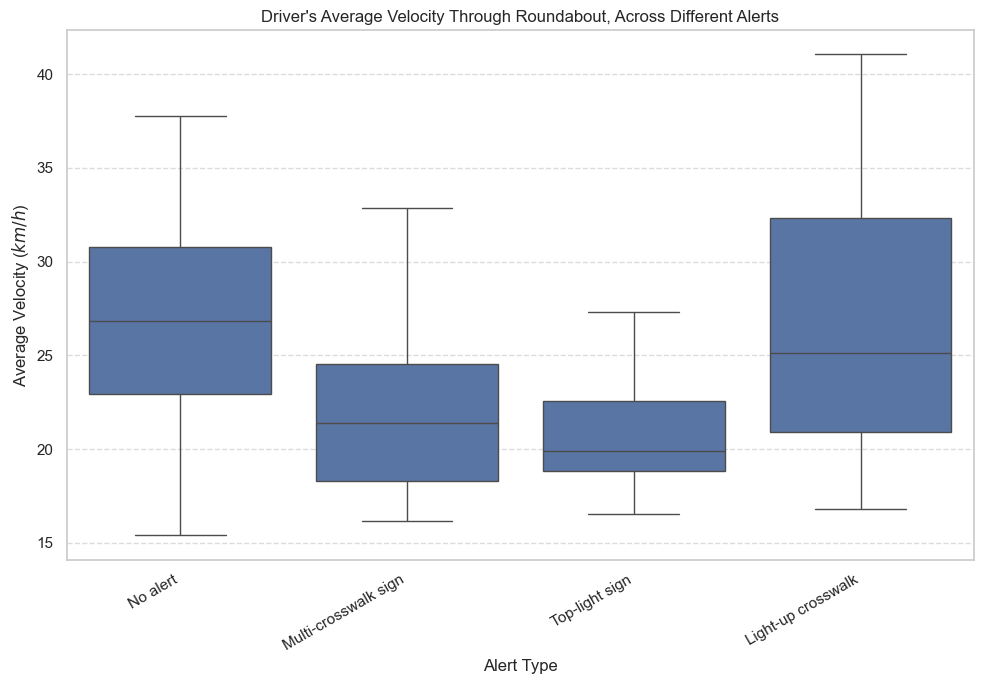

In [50]:
df = pd.read_csv("Compiled_Velocity_Data.csv")
df = df[~df["Alert_Combination"].isin(["Sign 3 + crosswalk", "Sign 2 + crosswalk"])]

summary_stats = df.groupby("Alert_Combination")["Avg_Velocity"].agg(['mean', 'std']).sort_values(by="mean")
print(summary_stats.round(2))

df["Alert_Combination"] = (
    df["Alert_Combination"]
    .str.replace("Sign 2", "Multi-crosswalk sign", regex=False)
    .str.replace("Sign 3", "Top-light sign", regex=False)
    .str.replace("Crosswalk", "Light-up crosswalk", regex=False)
)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 7))

sns.boxplot(
    data=df,
    x="Alert_Combination",
    y="Avg_Velocity",
    showfliers=False,
    # showmeans=True,
    # meanline=True,
    # meanprops={
    #     'color': 'limegreen',
    #     'linewidth': 1.5
    # },
    # boxprops={
    #     'facecolor': '#006E51',
    #     'edgecolor': 'black'
    # },
    # medianprops={
    #     'color': 'none'
    # }
)

plt.gca().yaxis.set_major_locator(MultipleLocator(5))

plt.title("Driver's Average Velocity Through Roundabout, Across Different Alerts")
plt.xlabel("Alert Type")
plt.ylabel(r"Average Velocity (${km/h}$)")

plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

## Braking Distance Analysis


### Pre-processing

- For this test, look only at trials where participants actually needed to brake for the pedestrian
- Estimate when the driver starts braking for the pedestrian based on acceleration patterns
- Determine if the alert type has an effect on the distance at which the driver brakes


In [18]:
relevant_trials = {5, 9, 13, 15, 16} # braking trials
input_dir = "Processed CSVs"
output_dir = "Braking Distance Analysis CSVs"

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.search(r'_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Could not extract trial number")
        continue
    
    trial_number = int(match.group(1))

    # Skip irrelevant trials
    if trial_number not in relevant_trials:
        print(f"Skipping {file}: Trial {trial_number} is not relevant")
        continue

    file_path = os.path.join(input_dir, file)
    df = pd.read_csv(file_path)

    if "Roundabout.EgoPedEuclideanDistance" not in df.columns:
        print(f"Skipping {file}: Missing required column")
        continue

    # assume they start braking for ped. somewhere in this window
    distance_cutoff = 40

    # Filter rows that have both non-zero AND <= cutoff start distance
    valid_start_rows = df[(df["Roundabout.EgoPedEuclideanDistance"] > 0) & 
                          (df["Roundabout.EgoPedEuclideanDistance"] <= distance_cutoff)]
    
    if valid_start_rows.empty:
        print(f"Skipping {file}: Simulink model failed to capture distance from pedestrian")
        continue

    # Get the first row where distance from ped. conditions are met
    start_index = valid_start_rows.index[0]

    df_filtered = df.loc[start_index:]

    min_distance_index = df_filtered["Roundabout.EgoPedEuclideanDistance"].idxmin()

    df_filtered = df.loc[start_index:min_distance_index]

    output_path = os.path.join(output_dir, file)
    df_filtered.to_csv(output_path, index=False)

Skipping Hassan_7.csv: Trial 7 is not relevant
Skipping Adity_12.csv: Trial 12 is not relevant
Skipping Pete_8.csv: Trial 8 is not relevant
Skipping Hassan_6.csv: Trial 6 is not relevant
Skipping Ionel_14.csv: Trial 14 is not relevant
Skipping Hassan_4.csv: Trial 4 is not relevant
Skipping Adity_10.csv: Trial 10 is not relevant
Skipping Adity_11.csv: Trial 11 is not relevant
Skipping Pete_14.csv: Trial 14 is not relevant
Skipping Hassan_5.csv: Simulink model failed to capture distance from pedestrian
Skipping Azaan_14.csv: Trial 14 is not relevant
Skipping Azaan_10.csv: Trial 10 is not relevant
Skipping Hassan_1.csv: Trial 1 is not relevant
Skipping Pete_10.csv: Trial 10 is not relevant
Skipping Ionel_8.csv: Trial 8 is not relevant
Skipping Adity_14.csv: Trial 14 is not relevant
Skipping Pete_11.csv: Trial 11 is not relevant
Skipping Azaan_11.csv: Trial 11 is not relevant
Skipping Ionel_12.csv: Trial 12 is not relevant
Skipping Ionel_10.csv: Trial 10 is not relevant
Skipping Hassan_2.c

### Format for analysis

Find the braking window that most likely corresponds to the driver braking for the pedestrian.


In [26]:

braking_threshold = -0.1

# minimum number of timestamps of negative acceleration to be considered one braking event
min_cluster_duration = 10

input_dir = "Braking Distance Analysis CSVs"
output_file = "Compiled_Braking_Distance_Data.csv"

compiled_data = []

csv_files = [f for f in os.listdir(input_dir) if f.endswith(".csv")]

for file in csv_files:
    match = re.match(r'(.+?)_(\d+)\.csv$', file)
    if not match:
        print(f"Skipping {file}: Filename does not match expected format.")
        continue

    participant_name, trial_number = match.groups()
    trial_number = int(trial_number)

    if trial_number not in trial_IVs:
        print(f"Skipping {file}: Trial {trial_number} is not in IV mapping.")
        continue

    file_path = os.path.join(input_dir, file)
    
    df = pd.read_csv(file_path)

    if "Longitudinal Acceleration" not in df.columns:
        print(f"Skipping {file}: Missing 'Longitudinal Acceleration' column.")
        continue

    accel_series = df["Longitudinal Acceleration"].reset_index(drop=True)

    clusters = []
    in_cluster = False
    cluster_start = None

    for i, accel in enumerate(accel_series):
        if accel < braking_threshold:
            if not in_cluster:
                in_cluster = True
                cluster_start = i
        else:
            if in_cluster:
                cluster_end = i
                duration = cluster_end - cluster_start
                if duration >= min_cluster_duration:
                    cluster = {
                        "start_idx": cluster_start,
                        "end_idx": cluster_end,
                        "duration": duration,
                        "min_accel": accel_series.iloc[cluster_start:cluster_end].min(),
                        "distance_start": df.iloc[cluster_start]["Roundabout.EgoPedEuclideanDistance"]
                    }
                    clusters.append(cluster)
                in_cluster = False
                cluster_start = None

    # Handle cluster that goes to the end
    if in_cluster:
        cluster_end = len(accel_series)
        duration = cluster_end - cluster_start
        if duration >= min_cluster_duration:
            cluster = {
                "start_idx": cluster_start,
                "end_idx": cluster_end,
                "duration": duration,
                "min_accel": accel_series.iloc[cluster_start:cluster_end].min(),
                "distance_start": df.iloc[cluster_start]["Roundabout.EgoPedEuclideanDistance"]
            }
            clusters.append(cluster)
    
    # Try to estimate braking cluster that's most likely the driver braking for the pedestrian
    likely_clusters = [c for c in clusters if c["distance_start"] <= 25]

    if not likely_clusters:
        print(f"{file}: No braking cluster within close range to pedestrian.")
        selected_cluster = min(clusters, key=lambda x: x["min_accel"])
        braking_start_index = selected_cluster["start_idx"]
        braking_distance = selected_cluster["distance_start"]
    else:
        # Save distance from pedestrian at the start of braking
        selected_cluster = min(likely_clusters, key=lambda x: x["min_accel"])
        braking_start_index = selected_cluster["start_idx"]
        braking_distance = selected_cluster["distance_start"]

    iv_data = trial_IVs[trial_number]
    compiled_data.append({
        "Participant": participant_name,
        "Trial": trial_number,
        "Braking_Distance": braking_distance,
        "Driver_Direction": iv_data["Driver's Direction"],
        "Alert_Combination": iv_data["Alert Combination"],
        "Pedestrian_Crossing": iv_data["Pedestrian Crossing"]
    })

compiled_df = pd.DataFrame(compiled_data)
compiled_df.to_csv(output_file, index=False)

Azaan_16.csv: No braking cluster within close range to pedestrian.
Pete_9.csv: No braking cluster within close range to pedestrian.
Adity_13.csv: No braking cluster within close range to pedestrian.
Azaan_15.csv: No braking cluster within close range to pedestrian.
Ionel_13.csv: No braking cluster within close range to pedestrian.
Pete_13.csv: No braking cluster within close range to pedestrian.
Azaan_9.csv: No braking cluster within close range to pedestrian.
Kapi_5.csv: No braking cluster within close range to pedestrian.
Sabina_13.csv: No braking cluster within close range to pedestrian.
Jenn_9.csv: No braking cluster within close range to pedestrian.
Eric_5.csv: No braking cluster within close range to pedestrian.
Madhav_5.csv: No braking cluster within close range to pedestrian.
Calvin_5.csv: No braking cluster within close range to pedestrian.
Mayurah_15.csv: No braking cluster within close range to pedestrian.
Jenn_5.csv: No braking cluster within close range to pedestrian.
Kapi

### ANOVA


In [28]:
df = pd.read_csv("Compiled_Braking_Distance_Data.csv")

# Run repeated measures ANOVA with Alert_Combination as the within-subjects factor
anova_results = pg.rm_anova(
    dv="Braking_Distance", 
    within="Alert_Combination",
    subject="Participant", 
    data=df, 
    detailed=True
)
print("\nRepeated-Measures ANOVA for Alert Combination:\n", anova_results)

# If significant, run post-hoc tests
if anova_results.loc[0, 'p-unc'] < 0.05:
    posthoc = pg.pairwise_ttests(
        dv="Braking_Distance",
        within="Alert_Combination",
        subject="Participant",
        data=df,
    )
    print("\nPost-hoc tests:\n", posthoc)


Repeated-Measures ANOVA for Alert Combination:
               Source           SS  DF          MS         F     p-unc  \
0  Alert_Combination   457.925968   3  152.641989  1.373613  0.312157   
1              Error  1000.120100   9  111.124456       NaN       NaN   

        ng2       eps  
0  0.261836  0.585847  
1       NaN       NaN  


Visualize:


                    mean    std
Alert_Combination              
No alert           19.27   7.72
Sign 2             19.82   9.88
Crosswalk          24.15  11.48
Sign 3             25.12  11.12


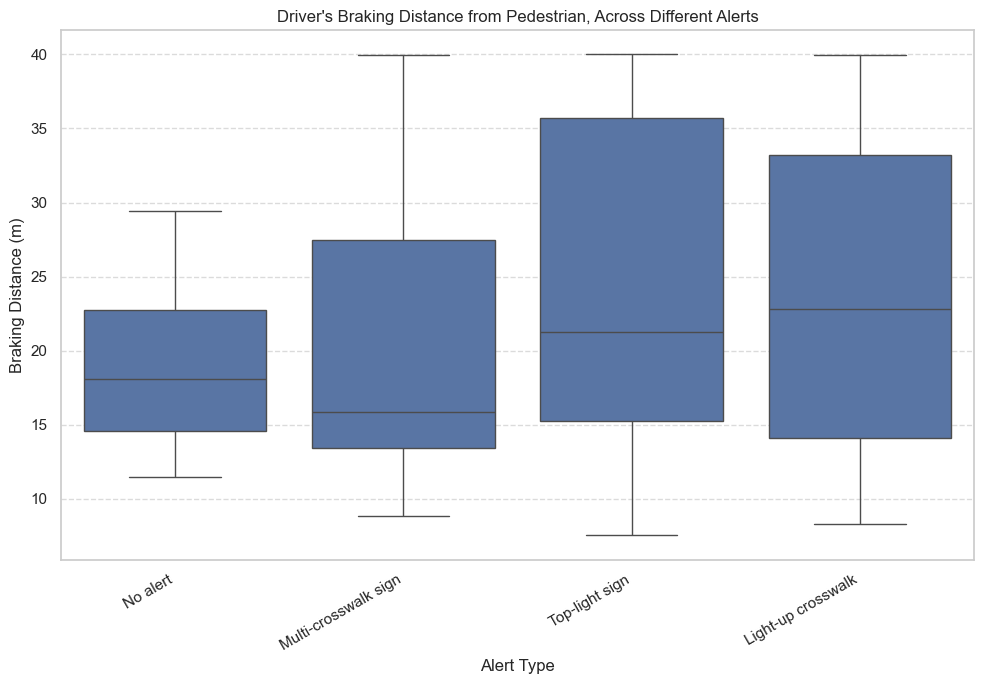

In [51]:
df = pd.read_csv("Compiled_Braking_Distance_Data.csv")

summary_stats = df.groupby("Alert_Combination")["Braking_Distance"].agg(['mean', 'std']).sort_values(by="mean")
print(summary_stats.round(2))

df["Alert_Combination"] = (
    df["Alert_Combination"]
    .str.replace("Sign 2", "Multi-crosswalk sign", regex=False)
    .str.replace("Sign 3", "Top-light sign", regex=False)
    .str.replace("Crosswalk", "Light-up crosswalk", regex=False)
)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 7))

sns.boxplot(
    data=df,
    x="Alert_Combination",
    y="Braking_Distance",
    showfliers=False,
    # showmeans=True,
    # meanline=True,
    # meanprops={
    #     'color': 'limegreen',
    #     'linewidth': 1.5
    # },
    # boxprops={
    #     'facecolor': '#006E51',
    #     'edgecolor': 'black'
    # },
    # medianprops={
    #     'color': 'none'
    # }
)


plt.gca().yaxis.set_major_locator(MultipleLocator(5))

plt.title("Driver's Braking Distance from Pedestrian, Across Different Alerts")
plt.xlabel("Alert Type")
plt.ylabel(r"Braking Distance (m)")

plt.xticks(rotation=30, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()